# input data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re 
import itertools
%matplotlib inline

In [2]:
data_train=pd.read_csv('datasimple(2).csv')
data_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,Distance,DepTime_hour,DepTime_min,mae_Afternoon,mae_Morning,mae_Night,...,region_orig_other,ctype_large,ctype_medium,ctype_small,new_month,less_UC,airport_comb_p,airport_comb_n,airport_comb_e,ap_comb
0,8,21,7,1934,732,19,34,0,0,1,...,0,2,0,0,0,0,0,0,1,0
1,4,20,3,1548,834,15,48,1,0,0,...,1,2,0,0,-1,0,0,0,1,0
2,9,2,5,1422,416,14,22,1,0,0,...,1,2,0,0,0,0,0,1,0,-1
3,11,25,6,1015,872,10,15,0,1,0,...,1,2,0,0,-1,0,1,0,0,1
4,10,7,6,1828,423,18,28,0,0,1,...,0,2,0,0,-1,0,0,0,1,0


In [3]:
data_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 53 columns):
Month                         100000 non-null int64
DayofMonth                    100000 non-null int64
DayOfWeek                     100000 non-null int64
DepTime                       100000 non-null int64
Distance                      100000 non-null int64
DepTime_hour                  100000 non-null int64
DepTime_min                   100000 non-null int64
mae_Afternoon                 100000 non-null int64
mae_Morning                   100000 non-null int64
mae_Night                     100000 non-null int64
Dest_type_large_airport       100000 non-null int64
Dest_type_medium_airport      100000 non-null int64
Dest_type_small_airport       100000 non-null int64
Origin_type_large_airport     100000 non-null int64
Origin_type_medium_airport    100000 non-null int64
Origin_type_small_airport     100000 non-null int64
region_dest_US-AK             100000 non-null int64
region

# Random Forest

## first one (without resampling)

Consider only mae, Distance, DepTime_hour, region_dest, region_orig, new_month, use class_label='balanced', without resampling.

In [3]:
from sklearn.model_selection import train_test_split

X=data_train
y=pd.read_csv('label.csv')
y=y.dep_delayed_15min

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123,stratify=y)
X_train.head()


,Month,DayofMonth,DayOfWeek,DepTime,Distance,DepTime_hour,DepTime_min,mae_Afternoon,mae_Morning,mae_Night,...,region_orig_other,ctype_large,ctype_medium,ctype_small,new_month,less_UC,airport_comb_p,airport_comb_n,airport_comb_e,ap_comb
56092,10,21,6,1555,102,15,55,1,0,0,...,0,1,1,0,-1,-1,0,0,0,0
4456,7,23,7,1118,1449,11,18,0,1,0,...,1,2,0,0,1,1,0,0,0,0
47685,10,1,7,1832,1464,18,32,0,0,1,...,1,2,0,0,-1,0,0,0,0,0
4721,4,18,2,1701,689,17,1,1,0,0,...,0,2,0,0,-1,1,0,0,0,0
4688,8,9,2,607,954,6,7,0,0,1,...,1,2,0,0,0,1,0,0,0,0


In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rfpipe = RandomForestClassifier(n_estimators=100,n_jobs=-1,class_weight='balanced', max_depth=15, random_state=123)
                      
rfpipe.fit(X_train, y_train)
y_pred_rf = rfpipe.predict(X_test)
cmatrix_rf = confusion_matrix(y_test, y_pred_rf, labels=None, sample_weight=None)
print('Test Accuracy: ', rfpipe.score(X_test, y_test), '\n Train Accuracy: ', rfpipe.score(X_train, y_train))

Test Accuracy:  0.6823 
 Train Accuracy:  0.7468285714285714


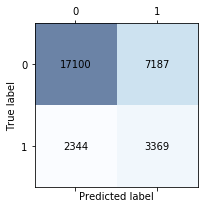

In [48]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cmatrix_rf, cmap=plt.cm.Blues,alpha=0.6)
for i in range(cmatrix_rf.shape[0]):
    for j in range(cmatrix_rf.shape[1]):
        ax.text(x=j, y=i, s=cmatrix_rf[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('cm1.png', dpi=300)
plt.show()

In [49]:
from sklearn.metrics import recall_score
rs_org_rf=recall_score(y_test, y_pred_rf, labels=True, pos_label=1, average='binary', sample_weight=None)
from sklearn.metrics import precision_score
ps_org_rf=precision_score(y_test, y_pred_rf, labels=None, pos_label=1, average='binary', sample_weight=None)
from sklearn.metrics import f1_score
f1_org_rf=f1_score(y_test, y_pred_rf, labels=None, pos_label=1, average='binary', sample_weight=None)

print(' recall_score : ',rs_org_rf,'\n precision_score : ',ps_org_rf,'\n f1_score : ',f1_org_rf)

 recall_score :  0.5897076842289515 
 precision_score :  0.3191549829480864 
 f1_score :  0.4141619030057164


### KFold validation

In [84]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(estimator=rfpipe,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=-1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.68990144 0.69271429 0.68514286 0.68928571 0.68171429 0.68771429
 0.68471429 0.69071429 0.683      0.68852693]
CV accuracy: 0.687 +/- 0.003


### Learning Curve

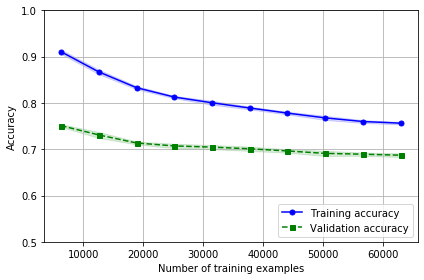

In [9]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=rfpipe,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

### ROC and AUC

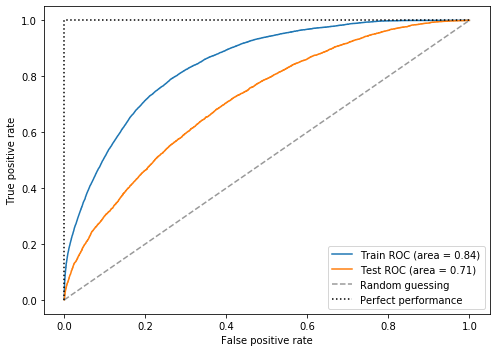

In [10]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

fig = plt.figure(figsize=(7, 5))

#############################################################
### TRAINING ROC CURVE
train_probas = rfpipe.fit(X_train,
                            y_train).predict_proba(X_train)

fpr, tpr, thresholds = roc_curve(y_train,
                                 train_probas[:, 1],
                                 pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,
         tpr,
         label='Train ROC (area = %0.2f)'
               % (roc_auc))

#############################################################
### TEST ROC CURVE
test_probas = rfpipe.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test,
                                 test_probas[:, 1],
                                 pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,
         tpr,
         label='Test ROC (area = %0.2f)'
               % (roc_auc))
#############################################################

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig('roc1.png', dpi=300)
plt.show()

### Grid Search CV

In [18]:
# max_depth and criterion 
from sklearn.model_selection import GridSearchCV

param_grid = [{'randomforestclassifier__max_depth': range(8,32,4)}]

scoring = {'rec': 'recall', 'acc': 'accuracy'}

rfpipe = make_pipeline(RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=123))

gs = GridSearchCV(estimator=rfpipe,
                  param_grid=param_grid,
                  iid=False,
                  n_jobs=-1,
                  scoring=scoring,
                  cv=5,
                 refit='rec', return_train_score=True)

gs.fit(X_train, y_train)

print(gs.best_score_)
print('Best Params:', gs.best_params_)

0.7215516196259413
Best Params: {'randomforestclassifier__max_depth': 8}


In [19]:
results = gs.cv_results_

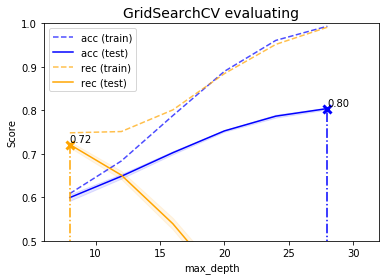

In [26]:
plt.title("GridSearchCV evaluating",
          fontsize=14)

plt.xlabel("max_depth")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(6, 32)
ax.set_ylim(0.5, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_randomforestclassifier__max_depth'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['blue', 'orange']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
#plt.savefig('gscv1.png', dpi=300)
plt.show()

## Second one (with oversampling SMOTE)

### SMOTE

In [28]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_resampled, y_resampled = SMOTE(random_state=123).fit_resample(X_train,y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 56669), (1, 56669)]


In [29]:
np.shape(X_resampled)

(113338, 53)

### second model

In [52]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rfpipe = RandomForestClassifier(n_estimators=100,n_jobs=-1,max_depth=28,random_state=123)
                      
rfpipe.fit(X_resampled, y_resampled)
y_pred_rf = rfpipe.predict(X_test)
cmatrix_rf = confusion_matrix(y_test, y_pred_rf, labels=None, sample_weight=None)
print('Test Accuracy: ', rfpipe.score(X_test, y_test), '\n Train Accuracy: ', rfpipe.score(X_resampled, y_resampled))

Test Accuracy:  0.7703666666666666 
 Train Accuracy:  0.9758797653958944


In [53]:
cmatrix_rf

array([[21520,  2767],
       [ 4122,  1591]], dtype=int64)

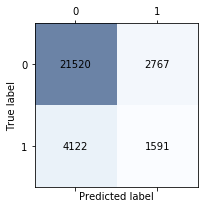

In [55]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cmatrix_rf, cmap=plt.cm.Blues,alpha=0.6)
for i in range(cmatrix_rf.shape[0]):
    for j in range(cmatrix_rf.shape[1]):
        ax.text(x=j, y=i, s=cmatrix_rf[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('cm2.png', dpi=300)
plt.show()

In [56]:
from sklearn.metrics import recall_score
rs_org_rf=recall_score(y_test, y_pred_rf, labels=True, pos_label=1, average='binary', sample_weight=None)
from sklearn.metrics import precision_score
ps_org_rf=precision_score(y_test, y_pred_rf, labels=None, pos_label=1, average='binary', sample_weight=None)
from sklearn.metrics import f1_score
f1_org_rf=f1_score(y_test, y_pred_rf, labels=None, pos_label=1, average='binary', sample_weight=None)

print(' recall_score : ',rs_org_rf,'\n precision_score : ',ps_org_rf,'\n f1_score : ',f1_org_rf)

 recall_score :  0.27848765972343775 
 precision_score :  0.3650757228086278 
 f1_score :  0.31595670737761894


### Cross validation

In [41]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(estimator=rfpipe,
                         X=X_resampled,
                         y=y_resampled,
                         cv=10,
                         n_jobs=-1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.68095994 0.68051879 0.77995412 0.83712723 0.83589201 0.83545086
 0.83280395 0.83492148 0.83130404 0.83242146]
CV accuracy: 0.798 +/- 0.061


### Learning Curve

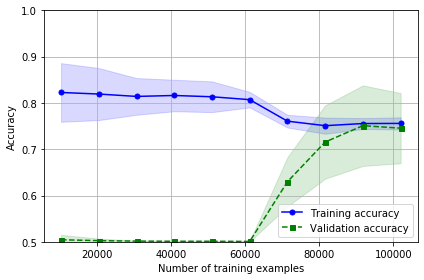

In [15]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=rfpipe,
                               X=X_resampled,
                               y=y_resampled,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

### ROC and AUC

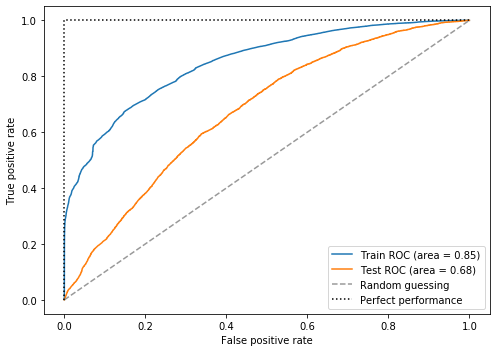

In [16]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

fig = plt.figure(figsize=(7, 5))

#############################################################
### TRAINING ROC CURVE
train_probas = rfpipe.fit(X_resampled,
                            y_resampled).predict_proba(X_resampled)

fpr, tpr, thresholds = roc_curve(y_resampled,
                                 train_probas[:, 1],
                                 pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,
         tpr,
         label='Train ROC (area = %0.2f)'
               % (roc_auc))

#############################################################
### TEST ROC CURVE
test_probas = rfpipe.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test,
                                 test_probas[:, 1],
                                 pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,
         tpr,
         label='Test ROC (area = %0.2f)'
               % (roc_auc))
#############################################################

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

### Grid Search CV

In [30]:
# max_depth and criterion 
from sklearn.model_selection import GridSearchCV

param_grid = [{'randomforestclassifier__max_depth': range(8,32,4)}]

scoring = {'rec': 'recall', 'acc': 'accuracy'}

rfpipe = make_pipeline(RandomForestClassifier(n_estimators=100, random_state=123))

gs = GridSearchCV(estimator=rfpipe,
                  param_grid=param_grid,
                  iid=False,
                  n_jobs=-1,
                  scoring=scoring,
                  cv=5,
                  refit='rec', return_train_score=True)

gs.fit(X_resampled, y_resampled)

print(gs.best_score_)
print('Best Params:', gs.best_params_)

0.7921291211021979
Best Params: {'randomforestclassifier__max_depth': 28}


In [31]:
results = gs.cv_results_

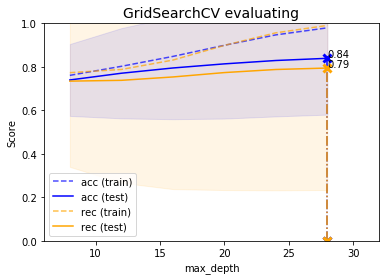

In [66]:
plt.title("GridSearchCV evaluating", fontsize=14)

plt.xlabel("max_depth")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(6, 32)
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_randomforestclassifier__max_depth'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['blue', 'orange']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
#plt.savefig('gscv2.png', dpi=300)
plt.show()

## Fourth one (with over and under sampling)

### SMOTETomek 

In [57]:
from imblearn.combine import SMOTETomek
st = SMOTETomek(random_state=123)
X_resampled, y_resampled = st.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 54560), (1, 54560)]


### forth model

In [58]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rfpipe = make_pipeline(RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=123))
                      
rfpipe.fit(X_resampled, y_resampled)

y_pred_rf = rfpipe.predict(X_test)
cmatrix_rf = confusion_matrix(y_test, y_pred_rf, labels=None, sample_weight=None)
rfpipe.score(X_test, y_test)

0.7044

In [59]:
cmatrix_rf

array([[18810,  5477],
       [ 3391,  2322]], dtype=int64)

In [60]:
from sklearn.metrics import recall_score
rs_org_rf=recall_score(y_test, y_pred_rf, labels=True, pos_label=1, average='binary', sample_weight=None)
from sklearn.metrics import precision_score
ps_org_rf=precision_score(y_test, y_pred_rf, labels=None, pos_label=1, average='binary', sample_weight=None)
from sklearn.metrics import f1_score
f1_org_rf=f1_score(y_test, y_pred_rf, labels=None, pos_label=1, average='binary', sample_weight=None)

print(' recall_score : ',rs_org_rf,'\n precision_score : ',ps_org_rf,'\n f1_score : ',f1_org_rf)

 recall_score :  0.4064414493260984 
 precision_score :  0.29773047826644444 
 f1_score :  0.34369449378330375


### CV

In [61]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(estimator=rfpipe,
                         X=X_resampled,
                         y=y_resampled,
                         cv=10,
                         n_jobs=-1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.68371515 0.68273841 0.78396377 0.83581957 0.83359972 0.83732907
 0.83262298 0.83741787 0.83552398 0.83738899]
CV accuracy: 0.800 +/- 0.060


### learning curve

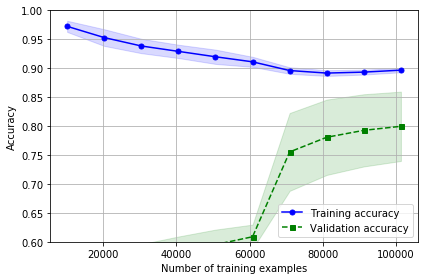

In [62]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=rfpipe,
                               X=X_resampled,
                               y=y_resampled,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=2)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.6, 1])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

### ROC and AUC

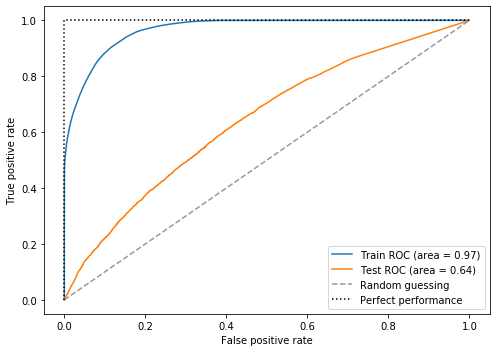

In [63]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

fig = plt.figure(figsize=(7, 5))

#############################################################
### TRAINING ROC CURVE
train_probas = rfpipe.fit(X_resampled,
                            y_resampled).predict_proba(X_resampled)

fpr, tpr, thresholds = roc_curve(y_resampled,
                                 train_probas[:, 1],
                                 pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,
         tpr,
         label='Train ROC (area = %0.2f)'
               % (roc_auc))

#############################################################
### TEST ROC CURVE
test_probas = rfpipe.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test,
                                 test_probas[:, 1],
                                 pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,
         tpr,
         label='Test ROC (area = %0.2f)'
               % (roc_auc))
#############################################################

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

### Grid Search

In [58]:
# max_depth and criterion 
from sklearn.model_selection import GridSearchCV

param_grid = [{'randomforestclassifier__max_depth': range(8,32,4)}]

scoring = {'rec': 'recall', 'acc': 'accuracy'}

rfpipe = make_pipeline(RandomForestClassifier(n_estimators=100, random_state=123))

gs = GridSearchCV(estimator=rfpipe,
                  param_grid=param_grid,
                  iid=False,
                  n_jobs=-1,
                  scoring=scoring,
                  cv=5,
                  refit='rec', return_train_score=True)

gs.fit(X_resampled, y_resampled)

print(gs.best_score_)
print('Best Params:', gs.best_params_)

0.7949230205278592
Best Params: {'randomforestclassifier__max_depth': 28}


In [60]:
results = gs.cv_results_

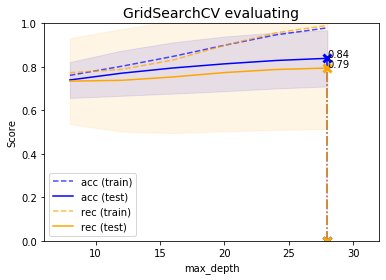

In [65]:
plt.title("GridSearchCV evaluating", fontsize=14)

plt.xlabel("max_depth")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(6, 32)
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_randomforestclassifier__max_depth'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['blue', 'orange']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.savefig('gscv3.png', dpi=300)
plt.show()